# **ResNet网络**

##### 导入所需库和数据

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

d:\anaconda\envs\pytorch\lib\site-packages\torch\cuda\__init__.py:54: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
d:\anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### 定义数据格式

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 5e-4
NUM_CLASSES = 10  # SVHN是0-9数字分类
TRAIN_NUM = 60000
TEST_NUM = 15000

#数据加载
# SVHN官方均值/方差，比简单0.5归一化更适配
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1980, 0.2010, 0.1970])
])
train = datasets.SVHN('data',split='train',download=True,transform=transform)
test = datasets.SVHN('data',split='test',download=True,transform=transform)

#随机采样
np.random.seed(42)
train_idx = np.random.choice(len(train), TRAIN_NUM, replace=True)
test_idx = np.random.choice(len(test), TEST_NUM, replace=True)
#Subset 只是 “引用” 原数据集的指定样本，不是把图片重新拷贝一份，节省内存
train_dataset = Subset(train, train_idx)# 从完整训练集train中，只取train_idx索引对应的1万张图片
test_dataset = Subset(test, test_idx)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)


Using downloaded and verified file: data\train_32x32.mat
Using downloaded and verified file: data\test_32x32.mat


# **定义训练模型**

##### 恒等映射残差块

In [3]:
class IdentityBlock(nn.Module):
    """基准组：恒等映射残差块（短接路径直接传x）"""
    def __init__(self, in_channels, out_channels):
        super(IdentityBlock, self).__init__()
        # 主路径：Conv-BN-ReLU-Conv-BN
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels) #批量归一化
        """
        卷积层输出的特征值会出现「分布漂移」（比如有的值很大、有的很小），导致网络学起来慢、容易震荡。
        BN 层会做两件事：
           把特征的均值拉到 0，方差拉到 1（标准化），让特征分布更稳定；
           加可学习的缩放 / 偏移参数，保留特征的有用信息。
        """
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x  # 短接路径（恒等/适配通道）
        out = F.relu(self.bn1(self.conv1(x)))  # 主路径第一步
        out = self.bn2(self.conv2(out))        # 主路径第二步
        out += residual                        # 残差相加
        out = F.relu(out)                      # 最终激活
        return out

##### 投影映射残差块

In [4]:
class ProjectionBlock(nn.Module):
    """对比组1：投影映射残差块（短接路径加1x1卷积）"""
    def __init__(self, in_channels, out_channels):
        super(ProjectionBlock, self).__init__()
        # 主路径：和恒等块完全一致（保证实验公平）
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 投影映射：用1x1卷积做线性变换
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        residual = self.shortcut(x)  # 短接路径（1x1卷积投影）
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

##### 全映射残差块

In [5]:
class FullMappingBlock(nn.Module):
    """对比组2：全映射残差块（短接路径加3x3卷积+BN+ReLU）"""
    def __init__(self, in_channels, out_channels):
        super(FullMappingBlock, self).__init__()
        # 主路径：和前两组完全一致
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 全映射：短接路径深度加工（3x3卷积+BN+ReLU）
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        residual = self.shortcut(x)  # 短接路径（深度加工）
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

##### 搭建ResNet模型

In [6]:
class ResNetExperiment(nn.Module):
    """ResNet（和论文结构对齐：初始卷积+残差层+池化+全连接）"""
    def __init__(self, block_type, num_classes=NUM_CLASSES):
        super(ResNetExperiment, self).__init__()
        # 初始卷积层（处理原始3通道输入）
        self.init_conv = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False)
        self.init_bn = nn.BatchNorm2d(32)  #批量归一化
        self.init_relu = nn.ReLU(inplace=True)
        
        # 残差层（堆叠2个残差块）
        self.res_block1 = block_type(32, 32)
        self.res_block2 = block_type(32, 32)
        self.res_block3 = block_type(32, 32)
        self.res_block4 = block_type(32, 32)
        self.res_block5 = block_type(32, 32)  
        self.res_block6 = block_type(32, 32)
        self.res_block7 = block_type(32, 32)  
        self.res_block8 = block_type(32, 32)

        # 池化+全连接（分类头）
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # 全局平均池化
        self.dropout = nn.Dropout(0.3)  # 强化正则化
        self.fc = nn.Linear(32, num_classes)


    def forward(self, x):
        # 初始卷积
        x = self.init_conv(x)
        x = self.init_bn(x)
        x = self.init_relu(x)
        
        # 残差块
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)
        x = self.res_block5(x)
        x = self.res_block6(x)
        x = self.res_block7(x)
        x = self.res_block8(x)

        # 分类
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)  # 展平
        x = self.dropout(x)
        x = self.fc(x)
        return x


# **训练模型**

In [7]:
def train_test_model(model, model_name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    #scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    
    # 新增：初始化列表记录每轮指标（和原来run函数一致）
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    
    print(f'\n========== 训练 {model_name} ==========')
    for epoch in range(EPOCHS):
        # 训练
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, pred = outputs.max(1)
            train_total += labels.size(0)
            train_correct += pred.eq(labels).sum().item()
        
        # 测试
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                _, pred = outputs.max(1)
                test_total += labels.size(0)
                test_correct += pred.eq(labels).sum().item()
        
        # 计算每轮指标并保存
        train_loss_avg = train_loss / train_total
        train_acc = 100. * train_correct / train_total
        test_loss_avg = test_loss / test_total
        test_acc = 100. * test_correct / test_total
        
        train_losses.append(train_loss_avg)
        train_accs.append(train_acc)
        test_losses.append(test_loss_avg)
        test_accs.append(test_acc)
        
        print(f'Epoch {epoch+1:2d} | 训练损失: {train_loss_avg:.4f} | 训练准确率: {train_acc:.2f}% | 测试损失: {test_loss_avg:.4f} | 测试准确率: {test_acc:.2f}%')
        #scheduler.step()
    
    torch.save(model.state_dict(), f'{model_name}_svhn.pth')
    # 修改返回值：返回所有轮次的指标列表（而非仅最终值）
    return train_losses, train_accs, test_losses, test_accs

##### 主函数

In [ ]:
if __name__ == '__main__':
    # 初始化3个模型
    model_identity = ResNetExperiment(IdentityBlock).to(DEVICE)
    model_projection = ResNetExperiment(ProjectionBlock).to(DEVICE)
    model_full = ResNetExperiment(FullMappingBlock).to(DEVICE)
    
    # 训练并获取【所有轮次】的loss/acc（而非仅最终值）
    identity_train_loss, identity_train_acc, identity_test_loss, identity_test_acc = train_test_model(model_identity, 'identity_block')
    projection_train_loss, projection_train_acc, projection_test_loss, projection_test_acc = train_test_model(model_projection, 'projection_block')
    full_train_loss, full_train_acc, full_test_loss, full_test_acc = train_test_model(model_full, 'full_mapping_block')


========== 训练 identity_block ==========
Epoch  1 | 训练损失: 1.6504 | 训练准确率: 42.99% | 测试损失: 0.9193 | 测试准确率: 69.87%
Epoch  2 | 训练损失: 0.6004 | 训练准确率: 82.61% | 测试损失: 0.4574 | 测试准确率: 86.70%
Epoch  3 | 训练损失: 0.4246 | 训练准确率: 87.76% | 测试损失: 0.3830 | 测试准确率: 89.00%
Epoch  4 | 训练损失: 0.3633 | 训练准确率: 89.64% | 测试损失: 0.2951 | 测试准确率: 91.71%
Epoch  5 | 训练损失: 0.3277 | 训练准确率: 90.67% | 测试损失: 0.3062 | 测试准确率: 91.25%
Epoch  6 | 训练损失: 0.2998 | 训练准确率: 91.50% | 测试损失: 0.2478 | 测试准确率: 92.89%
Epoch  7 | 训练损失: 0.2791 | 训练准确率: 92.11% | 测试损失: 0.2251 | 测试准确率: 93.79%
Epoch  8 | 训练损失: 0.2679 | 训练准确率: 92.48% | 测试损失: 0.2427 | 测试准确率: 93.44%
Epoch  9 | 训练损失: 0.2485 | 训练准确率: 93.04% | 测试损失: 0.2560 | 测试准确率: 92.93%
Epoch 10 | 训练损失: 0.2404 | 训练准确率: 93.30% | 测试损失: 0.2497 | 测试准确率: 92.89%

========== 训练 projection_block ==========
Epoch  1 | 训练损失: 1.5838 | 训练准确率: 45.52% | 测试损失: 0.7351 | 测试准确率: 78.39%
Epoch  2 | 训练损失: 0.5609 | 训练准确率: 84.40% | 测试损失: 0.3624 | 测试准确率: 89.89%
Epoch  3 | 训练损失: 0.3885 | 训练准确率: 88.99% | 测试损失: 0.3254 | 测试准确率: 

# **可视化训练结果**

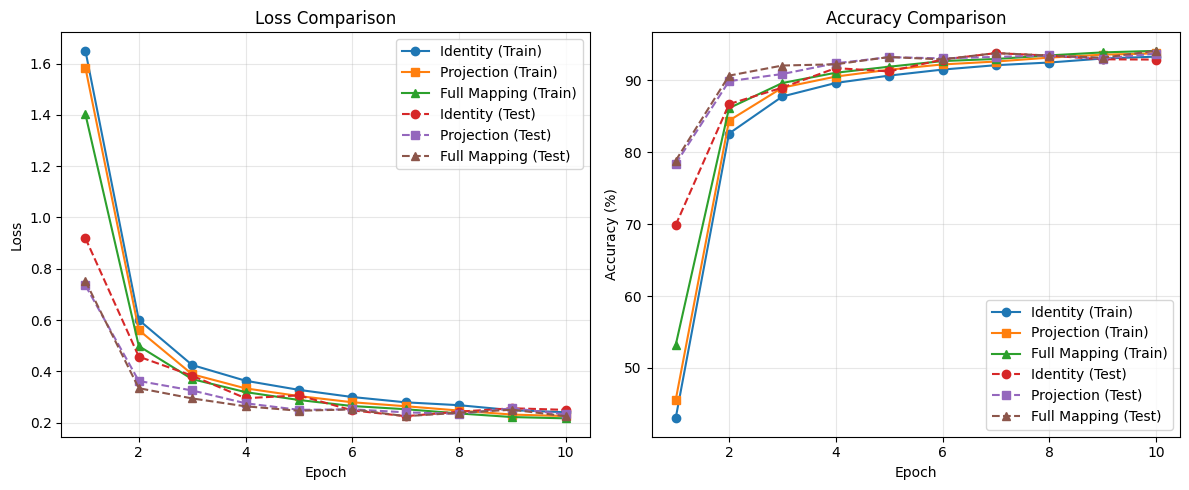


========== 实验结果汇总 ==========
恒等映射最终测试准确率: 92.89%
投影映射最终测试准确率: 93.73%
全映射最终测试准确率: 94.13%


In [9]:
def plot_results():
    """绘制3组模型的损失&准确率对比图"""
    epochs_range = range(1, EPOCHS+1)
    
    # 绘制损失曲线
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, identity_train_loss, label='Identity (Train)', marker='o')
    plt.plot(epochs_range, projection_train_loss, label='Projection (Train)', marker='s')
    plt.plot(epochs_range, full_train_loss, label='Full Mapping (Train)', marker='^')
    plt.plot(epochs_range, identity_test_loss, label='Identity (Test)', linestyle='--', marker='o')
    plt.plot(epochs_range, projection_test_loss, label='Projection (Test)', linestyle='--', marker='s')
    plt.plot(epochs_range, full_test_loss, label='Full Mapping (Test)', linestyle='--', marker='^')
    plt.title('Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, identity_train_acc, label='Identity (Train)', marker='o')
    plt.plot(epochs_range, projection_train_acc, label='Projection (Train)', marker='s')
    plt.plot(epochs_range, full_train_acc, label='Full Mapping (Train)', marker='^')
    plt.plot(epochs_range, identity_test_acc, label='Identity (Test)', linestyle='--', marker='o')
    plt.plot(epochs_range, projection_test_acc, label='Projection (Test)', linestyle='--', marker='s')
    plt.plot(epochs_range, full_test_acc, label='Full Mapping (Test)', linestyle='--', marker='^')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 保存图片
    plt.tight_layout()
    plt.savefig('resnet_block_comparison.png', dpi=300)
    plt.show()

# 生成可视化图
plot_results()

# ===================== 6. 实验结果汇总 =====================
print('\n========== 实验结果汇总 ==========')
print(f'恒等映射最终测试准确率: {identity_test_acc[-1]:.2f}%')
print(f'投影映射最终测试准确率: {projection_test_acc[-1]:.2f}%')
print(f'全映射最终测试准确率: {full_test_acc[-1]:.2f}%')